In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [10]:
from l5pc.model import L5PC_20D_theta, L5PC_20D_x
from l5pc.model.utils import return_x_names, return_names, return_xo, return_gt
import numpy as np
from pyloric import create_prior
import dill
import torch
from sbi.analysis import pairplot, marginal_plot
import matplotlib.pyplot as plt
from pyloric import simulate
from pyloric.utils import show_traces
from torch.distributions import biject_to
import pickle
from sbi.utils.user_input_checks import process_prior

In [4]:
from l5pc.utils.common_utils import (
    load_prior,
    extract_bounds,
    load_posterior,
)

In [30]:
t = L5PC_20D_theta()
x = L5PC_20D_x()

In [6]:
x

ind,round,step1_soma_ahp_depth_abs,step1_soma_ahp_depth_abs_slow,step1_soma_ahp_slow_time,step1_soma_ap_height,step1_soma_ap_width,step1_soma_isi_cv,step1_soma_adaptation_index2,step1_soma_doublet_isi,step1_soma_mean_frequency,step1_soma_time_to_first_spike,step2_soma_ahp_depth_abs,step2_soma_ahp_depth_abs_slow,step2_soma_ahp_slow_time,step2_soma_ap_height,step2_soma_ap_width,step2_soma_isi_cv,step2_soma_adaptation_index2,step2_soma_doublet_isi,step2_soma_mean_frequency,step2_soma_time_to_first_spike,step3_soma_ahp_depth_abs,step3_soma_ahp_depth_abs_slow,step3_soma_ahp_slow_time,step3_soma_ap_height,step3_soma_ap_width,step3_soma_isi_cv,step3_soma_adaptation_index2,step3_soma_doublet_isi,step3_soma_mean_frequency,step3_soma_time_to_first_spike,bap_dend1_ap_amplitude_from_voltagebase,bap_dend2_ap_amplitude_from_voltagebase,bap_soma_ap_height,bap_soma_ap_width,bap_soma_spikecount,id,path
0,1,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,57.6033,37.7233,36.5572,0.0,1.0,l20_0,none
1,1,-38.7995,nan,nan,-4.61307,0.5,nan,nan,nan,65.7895,15.2,-38.399,nan,nan,-4.0741,0.5,nan,nan,nan,84.0336,11.9,-35.2985,nan,nan,-2.515,0.6,nan,nan,nan,149.254,6.7,nan,nan,-6.32012,0.0,1.0,l20_0,none
2,1,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,nan,nan,26.105,0.0,1.0,l20_0,none
3,1,-52.5049,nan,nan,14.7478,0.4,nan,nan,nan,57.8035,17.3,-52.504,nan,nan,15.4935,0.4,nan,nan,nan,76.3359,13.1,-52.5038,nan,nan,18.3705,0.5,nan,nan,nan,142.857,7.0,nan,nan,20.6158,0.4,1.0,l20_0,none
4,1,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,76.3544,61.7537,12.247,0.0,1.0,l20_0,none
5,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,l20_0,none
6,1,-56.2502,nan,nan,37.9599,0.8,nan,nan,nan,45.6621,21.9,-56.0693,nan,nan,36.6459,0.8,nan,nan,nan,60.6061,16.5,-55.2833,nan,nan,37.2015,0.8,nan,nan,nan,116.279,8.6,17.1067,nan,40.2798,0.9,1.0,l20_0,none
7,1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,nan,nan,32.3269,0.0,1.0,l20_0,none
8,1,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,63.9111,45.3254,37.6956,0.0,1.0,l20_0,none
9,1,-62.2476,nan,nan,-5.85335,1.0,nan,nan,nan,57.1429,17.5,-62.7769,nan,nan,-5.3494,1.0,nan,nan,nan,72.9927,13.7,-63.6458,nan,nan,-3.42244,1.2,nan,nan,nan,129.87,7.7,60.5508,40.4738,1.22665,1.4,1.0,l20_0,none


In [11]:
with open(
    "/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/pyloric_restricted_prior.pkl",
    "rb",
) as handle:
    classifier2 = pickle.load(handle)

In [14]:
xo = torch.as_tensor(
    [
        1.17085859e03,
        2.06036434e02,
        2.14307031e02,
        4.12842187e02,
        1.75970382e-01,
        1.83034085e-01,
        3.52597820e-01,
        4.11600328e-01,
        6.30544893e-01,
        4.81925781e02,
        2.56353125e02,
        2.75164844e02,
        4.20460938e01,
        2.35011166e-01,
        3.59104797e-02,
        2.5,
        2.5,
        2.5,
    ]
)
prior = create_prior().numerical_prior
prior_pd = create_prior()
names = prior_pd.sample((1,)).columns
lower = prior.support.base_constraint.lower_bound
upper = prior.support.base_constraint.upper_bound
limits = torch.stack([lower, upper]).T

In [18]:
from sbi.utils.sbiutils import ImproperEmpirical

In [20]:
t = torch.rand(1000, 31)
fullprior = ImproperEmpirical(t, torch.ones(t.shape[0]))

In [29]:
for r in range(1,4):

    with open(f"/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/p31_2/multiround/2022_05_07__16_22_43__multirun/0/inference_r{r}.pkl", "rb") as handle:
        inference = dill.load(handle)
    print("loaded inference")

    posterior = inference[0].build_posterior().set_default_x(xo)
    posterior.prior = fullprior # create_prior().numerical_prior

    num_samples = 1000
    s = posterior.sample((num_samples,))
    inside_prior = torch.isfinite(prior.log_prob(s))
    inside_classifier = classifier2.predict(s)
    inside_full = torch.logical_and(inside_prior, inside_classifier)
    
    num_inside_prior = torch.sum(inside_full)
    frac_inside_prior = num_inside_prior / num_samples
    leakage = 1-frac_inside_prior
    print(f"R{r} leakage: {leakage}")

loaded inference


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

R1 leakage: 0.8199999928474426
loaded inference


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

R2 leakage: 0.9739999771118164
loaded inference


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

R3 leakage: 0.9929999709129333


In [8]:
with open(
    "/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/pyloric_restricted_prior.pkl",
    "rb",
) as handle:
    classifier = pickle.load(handle)
classifier, _, _ = process_prior(classifier)

/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:390: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


In [11]:
with open(f"/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/p31_2/multiround/2022_05_07__11_14_52__multirun/0/inference_r4.pkl", "rb") as handle:
    inference_r4 = dill.load(handle)
with open(f"/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/p31_2/multiround/2022_05_07__11_14_52__multirun/0/inference_r5.pkl", "rb") as handle:
    inference_r5 = dill.load(handle)

RuntimeError: [enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 408000000 bytes. Error code 12 (Cannot allocate memory)

In [101]:
posterior_r4 = inference_r4[0].build_posterior().set_default_x(xo)
posterior_r5 = inference_r5[0].build_posterior().set_default_x(xo)
# posterior.prior = create_prior().numerical_prior

In [128]:
samples_r4 = posterior_r4.sample((1000000,))
samples_r5 = posterior_r5.sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

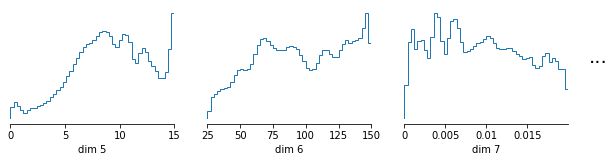

In [129]:
_ = marginal_plot(samples_r4, limits=limits, subset=[4, 5, 6], figsize=(10, 2))

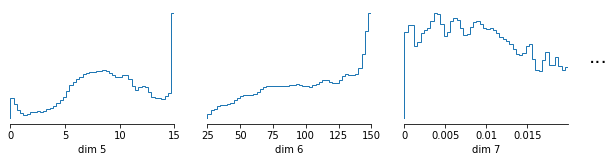

In [130]:
_ = marginal_plot(samples_r5, limits=limits, subset=[4, 5, 6], figsize=(10, 2))

In [131]:
bijection = biject_to(prior.support)

In [132]:
far_out_condition = samples_r5[:, 4] > 14.999
far_out_samples = samples_r5[far_out_condition]
far_out_samples_pd = pd.DataFrame(far_out_samples.numpy(), columns=names)

In [133]:
far_out_log_probs_r4 = posterior_r4.log_prob(far_out_samples)
far_out_log_probs_r5 = posterior_r5.log_prob(far_out_samples)
r5_sample_log_probs = posterior_r5.log_prob(samples_r5[:len(far_out_samples)])

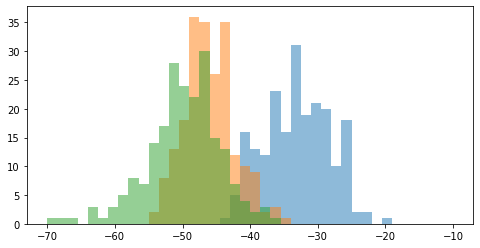

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = ax.hist(far_out_log_probs_r5.numpy(), bins=40, alpha=0.5, range=(-70,-10))
_ = ax.hist(r5_sample_log_probs.numpy(), bins=40, alpha=0.5, range=(-70,-10))
_ = ax.hist(far_out_log_probs_r4.numpy(), bins=40, alpha=0.5, range=(-70,-10))

In [95]:
tf_samples = bijection.inv(samples)

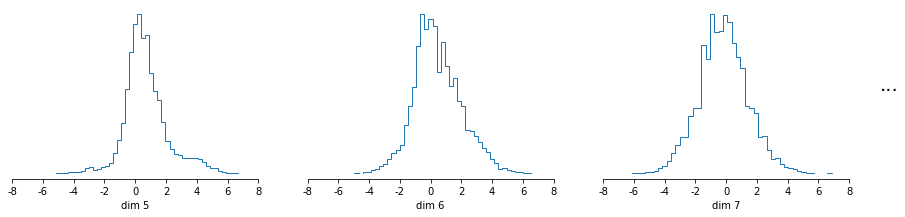

In [97]:
_ = marginal_plot(tf_samples, subset=[4, 5, 6], limits=[[-8,8]*3], figsize=(15, 3))

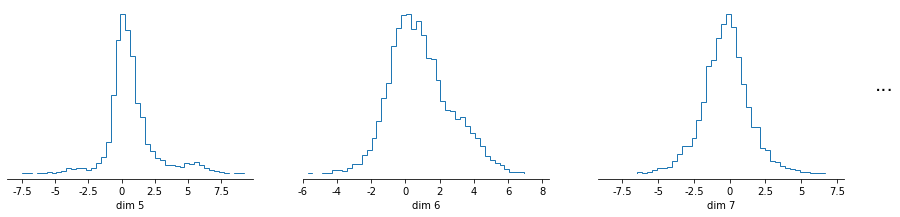

In [87]:
_ = marginal_plot(tf_samples, subset=[4, 5, 6], limits=[[-8,8]*3], figsize=(15, 3))

In [73]:
traces = [simulate(far_out_samples_pd.loc[i]) for i in range(10)]

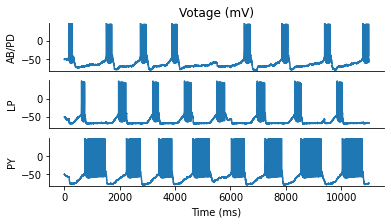

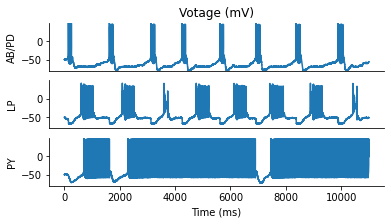

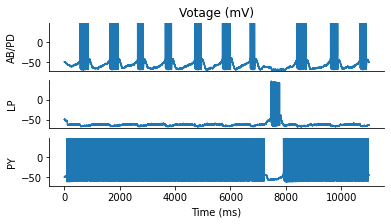

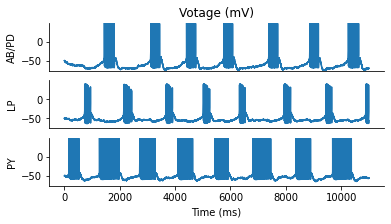

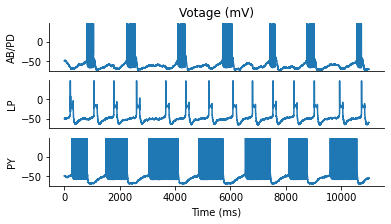

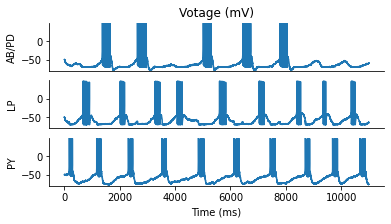

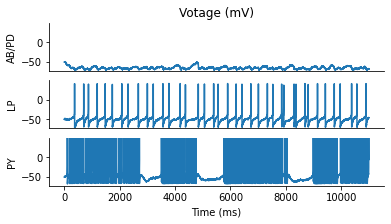

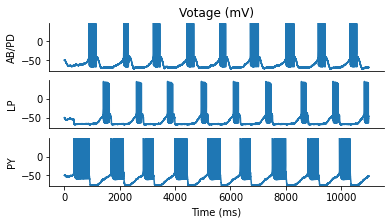

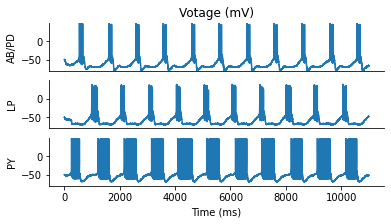

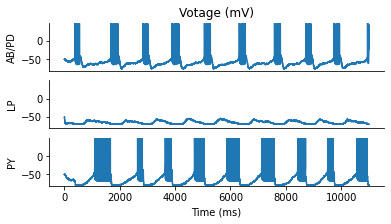

In [76]:
for j in range(10):
    _ = show_traces(traces[j])

In [ ]:
for r in range(1,4):

    with open(f"/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/p31_2/multiround/2022_05_07__16_22_43__multirun/0/inference_r{r}.pkl", "rb") as handle:
        inference = dill.load(handle)

    posterior = inference[0].build_posterior().set_default_x(xo)
    posterior.prior = create_prior().numerical_prior

    num_samples = 1000
    s = posterior.sample((num_samples,))
    leakage = 1 - (torch.sum(classifier2.predict(s)) / num_samples)
    print(f"R{r} leakage: {leakage}")

In [32]:
x & "id = 'l20_7'" & "round = 6"

ind,round,step1_soma_ahp_depth_abs,step1_soma_ahp_depth_abs_slow,step1_soma_ahp_slow_time,step1_soma_ap_height,step1_soma_ap_width,step1_soma_isi_cv,step1_soma_adaptation_index2,step1_soma_doublet_isi,step1_soma_mean_frequency,step1_soma_time_to_first_spike,step2_soma_ahp_depth_abs,step2_soma_ahp_depth_abs_slow,step2_soma_ahp_slow_time,step2_soma_ap_height,step2_soma_ap_width,step2_soma_isi_cv,step2_soma_adaptation_index2,step2_soma_doublet_isi,step2_soma_mean_frequency,step2_soma_time_to_first_spike,step3_soma_ahp_depth_abs,step3_soma_ahp_depth_abs_slow,step3_soma_ahp_slow_time,step3_soma_ap_height,step3_soma_ap_width,step3_soma_isi_cv,step3_soma_adaptation_index2,step3_soma_doublet_isi,step3_soma_mean_frequency,step3_soma_time_to_first_spike,bap_dend1_ap_amplitude_from_voltagebase,bap_dend2_ap_amplitude_from_voltagebase,bap_soma_ap_height,bap_soma_ap_width,bap_soma_spikecount,id,path
953240,6,-47.0272,nan,nan,31.3477,0.85,nan,nan,1289.5,1.51895,27.2,-46.0491,nan,nan,29.8291,0.75,nan,nan,1160.6,1.69391,20.1,-50.9349,-70.1816,0.0532888,14.2153,0.566667,nan,nan,9.5,2.80715,10.2,51.046,28.5894,38.744,0.9,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953241,6,-69.7005,-67.4825,0.0930713,25.9728,0.7,0.00304489,-0.00215306,868.8,2.08301,29.7,-70.5869,-67.8693,0.10674,26.0507,0.7,0.0051401,-0.0036346,897.6,2.29331,21.2,-69.6044,-67.3835,0.123024,25.5463,0.68,0.00949361,-0.00420458,880.5,2.83014,9.9,80.2319,67.2996,34.7607,0.8,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953242,6,-66.1604,-64.7183,0.134256,24.669,0.7,0.015291,0.00175277,66.4,3.54251,32.7,-65.789,-64.676,0.138941,23.9497,0.7125,0.0132378,-0.000384217,51.4,4.06318,23.0,-61.5729,-62.9732,0.140175,21.234,0.71,0.0957042,-0.0188001,19.9,5.36078,10.8,67.2205,51.8642,36.8007,0.9,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953243,6,-67.8759,-67.7351,0.0974175,22.386,0.56,0.0134749,0.00263953,252.5,5.05153,38.3,-66.2122,-66.0457,0.0893764,20.5025,0.558333,0.00766831,0.000957023,231.9,6.19323,25.3,-59.6334,-59.2836,0.102781,10.6641,0.515789,0.0129113,0.000740208,178.9,9.64516,11.7,67.8846,50.3614,33.9391,0.7,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953244,6,-64.4542,-64.465,0.0782117,28.9414,0.63,0.0204688,-0.00163042,81.6,10.203,33.0,-63.8043,-63.8015,0.088422,27.3937,0.62,0.0254838,-0.00185011,59.4,12.776,23.0,-60.4314,-60.3709,0.106409,20.5308,0.573684,0.040387,-0.00230192,28.1,19.4214,10.9,nan,nan,36.7057,0.7,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953245,6,-65.5689,-65.522,0.0192834,22.6467,0.5,0.171373,0.0451616,179.2,4.30269,53.8,-64.5338,-64.3955,0.0387914,21.2603,0.513333,0.18175,0.0363994,42.9,8.0064,28.8,-62.2704,-61.6358,0.255052,19.1374,0.498,0.0234323,-0.000430858,18.2,50.3778,11.4,67.9229,49.4133,36.036,0.6,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953246,6,-76.4471,nan,nan,28.9238,0.7,nan,nan,1171.7,1.66376,30.4,-75.0805,nan,nan,27.9142,0.7,nan,nan,1025.5,1.91022,21.5,-69.6254,-69.4922,0.0683841,20.6832,0.633333,nan,nan,799.7,1.93399,10.1,61.0707,39.0593,36.4684,0.8,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953247,6,-59.5014,nan,nan,24.9456,0.5,nan,nan,nan,34.2466,29.2,-59.5229,nan,nan,21.5755,0.5,nan,nan,nan,48.5437,20.6,-59.5318,nan,nan,21.9685,0.5,nan,nan,7.7,114.286,9.8,70.198,53.3866,30.1694,0.6,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953248,6,-74.8564,-73.1244,0.0471037,26.7516,0.766667,nan,nan,843.9,1.62522,31.8,-74.1894,-71.5554,0.0510782,26.3202,0.8,nan,nan,702.3,1.92963,22.3,-68.9596,-65.571,0.0579283,18.7685,0.75,0.0220661,-0.0156031,423.5,2.43117,10.5,55.9247,34.1246,37.6573,0.9,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0
953249,6,-66.9193,-66.82,0.0913016,32.3282,0.7,0.159994,0.0442167,178.1,4.57326,28.0,-67.0649,-66.9523,0.107528,32.1099,0.69,0.161738,0.034921,164.9,5.279,20.2,-65.9537,-65.9447,0.131923,29.3514,0.692857,0.157452,0.0234939,132.1,7.14687,9.7,68.4945,49.8958,37.9096,0.8,1.0,l20_7,2022_05_07__10_59_09_l5pc_m/0


In [33]:
x_fetched_r1 = (x & "id = 'l20_0'" & "round = 1").fetch(*return_x_names())
x_fetched_r2 = (x & "id = 'l20_7'" & "round = 2").fetch(*return_x_names())
x_fetched_r3 = (x & "id = 'l20_7'" & "round = 3").fetch(*return_x_names())
x_fetched_r4 = (x & "id = 'l20_7'" & "round = 4").fetch(*return_x_names())
x_fetched_r5 = (x & "id = 'l20_7'" & "round = 5").fetch(*return_x_names())
x_fetched_r6 = (x & "id = 'l20_7'" & "round = 6").fetch(*return_x_names())

In [34]:
x_r1_np = np.asarray(x_fetched_r1).T[:30000]
x_r2_np = np.asarray(x_fetched_r2).T[:30000]
x_r3_np = np.asarray(x_fetched_r3).T[:30000]
x_r4_np = np.asarray(x_fetched_r4).T[:30000]
x_r5_np = np.asarray(x_fetched_r5).T[:30000]
x_r6_np = np.asarray(x_fetched_r6).T[:30000]

In [35]:
print(x_r1_np.shape)
print(x_r2_np.shape)
print(x_r3_np.shape)
print(x_r4_np.shape)
print(x_r5_np.shape)
print(x_r6_np.shape)

(30000, 35)
(30000, 35)
(30000, 35)
(30000, 35)
(30000, 35)
(30000, 35)


In [36]:
good_r1 = np.sum(np.invert(np.any(np.isnan(x_r1_np), axis=1)))
good_r2 = np.sum(np.invert(np.any(np.isnan(x_r2_np), axis=1)))
good_r3 = np.sum(np.invert(np.any(np.isnan(x_r3_np), axis=1)))
good_r4 = np.sum(np.invert(np.any(np.isnan(x_r4_np), axis=1)))
good_r5 = np.sum(np.invert(np.any(np.isnan(x_r5_np), axis=1)))
good_r6 = np.sum(np.invert(np.any(np.isnan(x_r6_np), axis=1)))

In [37]:
print("good_r1", good_r1)
print("good_r2", good_r2)
print("good_r3", good_r3)
print("good_r4", good_r4)
print("good_r5", good_r5)
print("good_r6", good_r6)

good_r1 11
good_r2 441
good_r3 3162
good_r4 6947
good_r5 10221
good_r6 17635


In [44]:
paths = (x & "id = 'l20_7'" & "round = 5").fetch("path")

In [45]:
for p in paths[::100]:
    print(p)

2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0
2022_05_06__15_24_17_l5pc_m/0


In [49]:
from sbi.utils import RestrictedPrior, RestrictionEstimator
import pickle
import dill

In [59]:
from sbi.utils import RestrictedPrior, RestrictionEstimator
import pickle

with open("/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/results/pyloric_restricted_prior.pkl", "rb") as handle:
    rp = pickle.load(handle)

In [60]:
from sbi.utils.user_input_checks import process_prior

In [61]:
p = process_prior(rp)

The classifier rejected 88.5% of all samples. You will get a speed-up of 769.0%.
The classifier rejected 88.6% of all samples. You will get a speed-up of 776.5%.
The classifier rejected 88.8% of all samples. You will get a speed-up of 790.6%.
The classifier rejected 88.6% of all samples. You will get a speed-up of 779.6%.


/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:390: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(


The classifier rejected 88.8% of all samples. You will get a speed-up of 790.0%.


/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(


The classifier rejected 88.4% of all samples. You will get a speed-up of 762.7%.


/mnt/qb/macke/mdeistler57/tsnpe_collection/sbi/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


The classifier rejected 88.3% of all samples. You will get a speed-up of 752.6%.
The classifier rejected 88.8% of all samples. You will get a speed-up of 791.4%.


In [73]:
class WrapperPrior(torch.distributions.Distribution):
    def __init__(self, prior):
        super().__init__()
        self.prior = prior
    def sample(self,num_samples):
        return self.prior.sample(num_samples)
    def log_prob(self,theta):
        return self.prior.log_prob(theta)

In [74]:
wp = WrapperPrior(rp)

/home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.WrapperPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [75]:
from sbi.inference import SNPE

In [76]:
i = SNPE(prior=wp)

The classifier rejected 88.2% of all samples. You will get a speed-up of 744.7%.


In [56]:
x

ind,round,step1_soma_ahp_depth_abs,step1_soma_ahp_depth_abs_slow,step1_soma_ahp_slow_time,step1_soma_ap_height,step1_soma_ap_width,step1_soma_isi_cv,step1_soma_adaptation_index2,step1_soma_doublet_isi,step1_soma_mean_frequency,step1_soma_time_to_first_spike,step2_soma_ahp_depth_abs,step2_soma_ahp_depth_abs_slow,step2_soma_ahp_slow_time,step2_soma_ap_height,step2_soma_ap_width,step2_soma_isi_cv,step2_soma_adaptation_index2,step2_soma_doublet_isi,step2_soma_mean_frequency,step2_soma_time_to_first_spike,step3_soma_ahp_depth_abs,step3_soma_ahp_depth_abs_slow,step3_soma_ahp_slow_time,step3_soma_ap_height,step3_soma_ap_width,step3_soma_isi_cv,step3_soma_adaptation_index2,step3_soma_doublet_isi,step3_soma_mean_frequency,step3_soma_time_to_first_spike,bap_dend1_ap_amplitude_from_voltagebase,bap_dend2_ap_amplitude_from_voltagebase,bap_soma_ap_height,bap_soma_ap_width,bap_soma_spikecount,id,path
0,1,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,-73.4808,nan,nan,35.9009,0.0,nan,nan,nan,0.0,-698.9,57.6033,37.7233,36.5572,0.0,1.0,l20_0,none
1,1,-38.7995,nan,nan,-4.61307,0.5,nan,nan,nan,65.7895,15.2,-38.399,nan,nan,-4.0741,0.5,nan,nan,nan,84.0336,11.9,-35.2985,nan,nan,-2.515,0.6,nan,nan,nan,149.254,6.7,nan,nan,-6.32012,0.0,1.0,l20_0,none
2,1,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,-75.3765,nan,nan,26.3433,0.0,nan,nan,nan,0.0,-698.9,nan,nan,26.105,0.0,1.0,l20_0,none
3,1,-52.5049,nan,nan,14.7478,0.4,nan,nan,nan,57.8035,17.3,-52.504,nan,nan,15.4935,0.4,nan,nan,nan,76.3359,13.1,-52.5038,nan,nan,18.3705,0.5,nan,nan,nan,142.857,7.0,nan,nan,20.6158,0.4,1.0,l20_0,none
4,1,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,-78.3215,nan,nan,12.1222,0.0,nan,nan,nan,0.0,-698.4,76.3544,61.7537,12.247,0.0,1.0,l20_0,none
5,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,l20_0,none
6,1,-56.2502,nan,nan,37.9599,0.8,nan,nan,nan,45.6621,21.9,-56.0693,nan,nan,36.6459,0.8,nan,nan,nan,60.6061,16.5,-55.2833,nan,nan,37.2015,0.8,nan,nan,nan,116.279,8.6,17.1067,nan,40.2798,0.9,1.0,l20_0,none
7,1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,-71.2597,nan,nan,31.4518,0.0,nan,nan,nan,0.0,-698.1,nan,nan,32.3269,0.0,1.0,l20_0,none
8,1,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,-72.9573,nan,nan,37.5783,0.0,nan,nan,nan,0.0,-698.6,63.9111,45.3254,37.6956,0.0,1.0,l20_0,none
9,1,-62.2476,nan,nan,-5.85335,1.0,nan,nan,nan,57.1429,17.5,-62.7769,nan,nan,-5.3494,1.0,nan,nan,nan,72.9927,13.7,-63.6458,nan,nan,-3.42244,1.2,nan,nan,nan,129.87,7.7,60.5508,40.4738,1.22665,1.4,1.0,l20_0,none


In [7]:
from sbi.utils.support_posterior import PosteriorSupport
import torch
from torch import ones
from sbi.utils import BoxUniform

In [8]:
prior = BoxUniform(-2*ones(1), 2*ones(1))

In [9]:
def my_sim(theta):
    return theta**2 + torch.randn(theta.shape)*0.2

In [10]:
from sbi.inference import SNPE

In [13]:
_ = torch.manual_seed(4)
inference = SNPE(prior, density_estimator="nsf")
proposal = prior
for _ in range(1):

    theta = proposal.sample((500,))
    x = my_sim(theta)

    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(torch.tensor([[1.2]]))
    proposal = PosteriorSupport(prior=prior, posterior=posterior, allowed_false_negatives=0.0001, sampling_method="sir", sir_oversample=64)
    net = posterior.posterior_estimator

Final theta shape in sbi.train:  torch.Size([500, 1])
Final x shape in sbi.train:  torch.Size([500, 1])
 Neural network successfully converged after 105 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

lps tensor([ 0.5329,  0.8640,  0.2873,  ..., -1.6017,  0.2625,  0.5279])
self.thr tensor(-6.2354)
prior_acceptance_rate tensor(1.)


In [29]:
_ = torch.manual_seed(2)
s = proposal.sample((10000,), show_progress_bars=True)

Sampling with SIR


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
t_eval = torch.linspace(-2, 2, 100).unsqueeze(1)
pred = proposal.predict(t_eval)

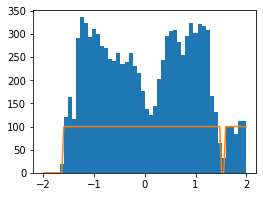

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = ax.hist(s[:, 0].numpy(), bins=50, range=(-2, 2))
_ = ax.plot(t_eval.numpy(), pred.numpy()*100)